## Predictor System

In [1]:
!pip install patchify

In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import patchify as patch
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import os,time
from datetime import datetime
from scipy.ndimage import rotate
import joblib

### Loading Model

In [3]:
!wget --header="Host: doc-0s-9k-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_82jcsesreiehjbhkrct3c4mrj1raokod_nonce=qucg6omvccnn8" --header="Connection: keep-alive" "https://doc-0s-9k-docs.googleusercontent.com/docs/securesc/rg90kivf62vcrm9d2s7vb24hsj0c3fo2/2542jpfnas0t1l3q0rbkkja2o8e62i27/1646753400000/00176583124175523585/00176583124175523585/1n553QOxdlLamQC0uYV5Td8BTxdh1LakI?e=download&ax=ACxEAsZboT7sjniaA4p9ko2ZYzXoDhzDEO8aRTEOC09kdm3VNXF8Ip7Pway7f-hZCdyTw8fJyw_yaPbR8wUF0vQJLKnU6WY76o2GYfiI3Lfg5aeL2gc4Xc0995viowp5MSJnwadCkl1chBOc81CaEeLyvTcgm03L9w_Q5qIF6mYdX0EyQdfJf5n_N3TAX-E8aywwM6zNjQQQoLNhDTOcB6Q3-ic7PU-jO1GWuM4yAX9ZYj-cgfaQOzqV9pbG8P42ltedmqfGhZ7yclK2kLLYLAuEYTGhFJQiSKCFcfdY570gpPavShGbTgwUkdxvwwoSR-_P8Y85xsH6_9KlslpGyAu9ERMFfj9wpUWCT6tBlQLi0yoECfTuIqY9Nh-fktZv_AFwYXoLbH1D4eXf9O23eEe43MY5WC3x799m60IzLBvVEcRLMwqaSqPW7w0RX_NXZAqi9qyqhcmpJM6sUBwe83GSOkDloxCOwiMAZKOMN3SZ1dC8Ptug1E3epD1OK9E2e-KUu0OoY5LS21-wTQpWJo568YSxRPADWO6D_Tf1AgEnJq6sC3ou1Dnt0YlSQBnohBEkSyJmy7Zp6Fye5dv8mjYLt0GzoOHrlrHz76FleZoyPGFqLMDTXcgRD4KmqlbTe_iR0zHRZxbcbXviMfxEFfQgEMkooXm9w0Fj5Mh5S_GN&authuser=0&nonce=qucg6omvccnn8&user=00176583124175523585&hash=udvo73m6kfiifo3t00k6j2fmdbsc79s0" -c -O 'Simple_UNET_64x64.joblib'

--2022-03-08 15:30:37--  https://doc-0s-9k-docs.googleusercontent.com/docs/securesc/rg90kivf62vcrm9d2s7vb24hsj0c3fo2/2542jpfnas0t1l3q0rbkkja2o8e62i27/1646753400000/00176583124175523585/00176583124175523585/1n553QOxdlLamQC0uYV5Td8BTxdh1LakI?e=download&ax=ACxEAsZboT7sjniaA4p9ko2ZYzXoDhzDEO8aRTEOC09kdm3VNXF8Ip7Pway7f-hZCdyTw8fJyw_yaPbR8wUF0vQJLKnU6WY76o2GYfiI3Lfg5aeL2gc4Xc0995viowp5MSJnwadCkl1chBOc81CaEeLyvTcgm03L9w_Q5qIF6mYdX0EyQdfJf5n_N3TAX-E8aywwM6zNjQQQoLNhDTOcB6Q3-ic7PU-jO1GWuM4yAX9ZYj-cgfaQOzqV9pbG8P42ltedmqfGhZ7yclK2kLLYLAuEYTGhFJQiSKCFcfdY570gpPavShGbTgwUkdxvwwoSR-_P8Y85xsH6_9KlslpGyAu9ERMFfj9wpUWCT6tBlQLi0yoECfTuIqY9Nh-fktZv_AFwYXoLbH1D4eXf9O23eEe43MY5WC3x799m60IzLBvVEcRLMwqaSqPW7w0RX_NXZAqi9qyqhcmpJM6sUBwe83GSOkDloxCOwiMAZKOMN3SZ1dC8Ptug1E3epD1OK9E2e-KUu0OoY5LS21-wTQpWJo568YSxRPADWO6D_Tf1AgEnJq6sC3ou1Dnt0YlSQBnohBEkSyJmy7Zp6Fye5dv8mjYLt0GzoOHrlrHz76FleZoyPGFqLMDTXcgRD4KmqlbTe_iR0zHRZxbcbXviMfxEFfQgEMkooXm9w0Fj5Mh5S_GN&authuser=0&nonce=qucg6omvccnn8&user=00176583124175523585&hash

### Image segmentation Predictor function definition

In [13]:
def Predict_HSI_segment(image):
  '''This predicts the segmentation of 16 classes of Indian Pines data and returns the segmentation matrix'''
  start = time.time()
  # Verify the image 
  if(image.shape==(145,145,200)):
    
    # Loading Model 
    Std_scaler = joblib.load('HSI_Std_Scaler_95.joblib')
    unet_m2 = joblib.load('Simple_UNET_64x64.joblib')
    
    # Reference for correlation feature filtering :  https://sachinbu.medium.com/hyperspectral-image-segmentation-21432965e138
    corr_feat_list = [7, 8, 9, 15, 24, 27, 28, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 58, 64, 65, 66, 67, 68, 69, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190]
  
    image_filtered = np.delete(image,corr_feat_list,-1)
    
    # standardize image features
    image_filtered_std = Std_scaler.transform(image_filtered.reshape(-1,image_filtered.shape[-1])).reshape(image_filtered.shape)
    
    stop = time.time()
    # print('standardize Processing time (sec): ',stop-start)

    # Generating the patches
    img_patch =  np.squeeze(patch.patchify(image_filtered_std, (64, 64,95) , step=9), axis=2)
    # stop = time.time()
    # print('patch gen Processing time (sec): ',stop-start)

    # Loading data associated with the image (145x145)
    HSI_dataset = []
    for i in range(img_patch.shape[0]):
      for j in range(img_patch.shape[1]):
        single_patch = img_patch[i][j]
        HSI_dataset.append(single_patch)
  
    # Converting original patch list to numpy array
    HSI_dataset = np.array(HSI_dataset)
    # stop = time.time()
    # print('dataset gen Processing time (sec): ',stop-start)

    # predicting for individual patch
    pred_prob  = unet_m2.predict(HSI_dataset)
    
    # stop = time.time()
    # print('pred_prob Processing time (sec): ',stop-start)
    
    # Generating the 3D probabilities grid of all patches associated with full image.
    grid = 0
    grp = 0
    img_prediction = np.zeros((145, 145, 100*17))
    for i in range(10):
      for j in range(10):
        img_prediction[i*9:i*9+64,
                       j*9:j*9+64,
                       grp:grp+17] = pred_prob[grid]
        grid+=1
        grp+=17
  
    # Identifying the classes of each pixel from probabilities values of all patches corresponding to image(145x145)
    prediction = np.argmax(img_prediction,axis=-1)%17

    stop = time.time()
    print('Processing time (sec): ',stop-start)
    
    return prediction

  else:
    print('image size must be 145x145x200')

### Loading  image

In [18]:
!wget wget --header="Host: www.ehu.eus" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes" "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat" -c -O 'Indian_pines_corrected.mat'

--2022-03-08 15:38:35--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2022-03-08 15:38:35--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M  2.09MB/s    in 2.7s    

2022-03-08 15:38:38 (2.09 MB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

FINISHED --2022-03-08 15:38:38--
Total wall clock time: 3.4s
Downloaded: 1 files, 5.7M in 2.7s (2.09 MB/s)


In [5]:
!wget --header="Host: doc-0s-9k-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_82jcsesreiehjbhkrct3c4mrj1raokod=00176583124175523585|1646753400000|3b4a88irmjdg5q4gvisaeb8c4tahj3tu" --header="Connection: keep-alive" "https://doc-0s-9k-docs.googleusercontent.com/docs/securesc/rg90kivf62vcrm9d2s7vb24hsj0c3fo2/eotcildd2n2i7uun4dpntmm4jokpgo0v/1646753475000/00176583124175523585/00176583124175523585/1Y37W47Bl0ibWZz2vFkVYvm9qjVhEk8jx?e=download&ax=ACxEAsb4crD0cQ4l4rdEj5Pz_vbraAyaK3MKKsLoNjSWoh1XbHAqxVtxKcTbUJvTObha_XBEi3D8C3JxYGYSv8HGuhly1cHilx4rohzHNnwTo0SIBkIoDagSFpI2qfcoKnWaXLMsvJz_OhN0ol2YKAIsOCnWieIzctCisU5oSr5RMt_0YIAZcbA2tlIkNR8cSVPv4MRpOUOcVcDnA6A7CFnHrUoBgddU5_LSaw4A3WC8E8TQ61zVTjqz3IE7Zpn7SMZ1qzN9-31L7n2qbLOCBwXygZfnHsltIstu8rD_BPddD8TpJTjeC-EjGOEqpmyKWrXmIOPSfDfuoaOdTiw7RbnXCR_MgGRK4_3gjxllT64LfQTUUu_3GwnVaDphk2XjZ-iTTRBTKZPUPIfZPiUDRW_u4Qo0XYrF-S5YOS_oVp1ih3G6lSyS5w48PyLSN-ugfOqB1UBZrWlMH3I-qjD5Icg0P_Kt2qPw5rb7t-CHi19sflD_g_XaoUfRYfe5i81zZyViFqUQTwV12lMcs8Mb8ZUra9wJqS6U-jdOYPJ950eeQa2MEVrxHgu5uSwBfpirz6BBvbQvGeR7dYu3F_1_l-KxLXrvZ_ojzTxnXn6V-TTMCQ9pu04h-GTWZyFUxLeEpm4x4njjHBmi-VhtzD9_3eNziI7kX_XxRBDmkRZedlg6&authuser=0" -c -O 'test_image_full.mat'

--2022-03-08 15:32:51--  https://doc-0s-9k-docs.googleusercontent.com/docs/securesc/rg90kivf62vcrm9d2s7vb24hsj0c3fo2/eotcildd2n2i7uun4dpntmm4jokpgo0v/1646753475000/00176583124175523585/00176583124175523585/1Y37W47Bl0ibWZz2vFkVYvm9qjVhEk8jx?e=download&ax=ACxEAsb4crD0cQ4l4rdEj5Pz_vbraAyaK3MKKsLoNjSWoh1XbHAqxVtxKcTbUJvTObha_XBEi3D8C3JxYGYSv8HGuhly1cHilx4rohzHNnwTo0SIBkIoDagSFpI2qfcoKnWaXLMsvJz_OhN0ol2YKAIsOCnWieIzctCisU5oSr5RMt_0YIAZcbA2tlIkNR8cSVPv4MRpOUOcVcDnA6A7CFnHrUoBgddU5_LSaw4A3WC8E8TQ61zVTjqz3IE7Zpn7SMZ1qzN9-31L7n2qbLOCBwXygZfnHsltIstu8rD_BPddD8TpJTjeC-EjGOEqpmyKWrXmIOPSfDfuoaOdTiw7RbnXCR_MgGRK4_3gjxllT64LfQTUUu_3GwnVaDphk2XjZ-iTTRBTKZPUPIfZPiUDRW_u4Qo0XYrF-S5YOS_oVp1ih3G6lSyS5w48PyLSN-ugfOqB1UBZrWlMH3I-qjD5Icg0P_Kt2qPw5rb7t-CHi19sflD_g_XaoUfRYfe5i81zZyViFqUQTwV12lMcs8Mb8ZUra9wJqS6U-jdOYPJ950eeQa2MEVrxHgu5uSwBfpirz6BBvbQvGeR7dYu3F_1_l-KxLXrvZ_ojzTxnXn6V-TTMCQ9pu04h-GTWZyFUxLeEpm4x4njjHBmi-VhtzD9_3eNziI7kX_XxRBDmkRZedlg6&authuser=0
Resolving doc-0s-9k-docs.googleusercontent.com (do

In [28]:
HS_image_1 = scipy.io.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
# HS_image

In [34]:
# %%timeit
# HS_image_1_segment = Predict_HSI_segment(HS_image_1)

Processing time (sec):  9.413984060287476
Processing time (sec):  12.010457515716553
Processing time (sec):  11.997580528259277
Processing time (sec):  11.995202541351318
Processing time (sec):  9.308510780334473
Processing time (sec):  11.977086782455444
1 loop, best of 5: 9.32 s per loop


In [35]:
HS_image_1_segment = Predict_HSI_segment(HS_image_1)

Processing time (sec):  9.889133214950562


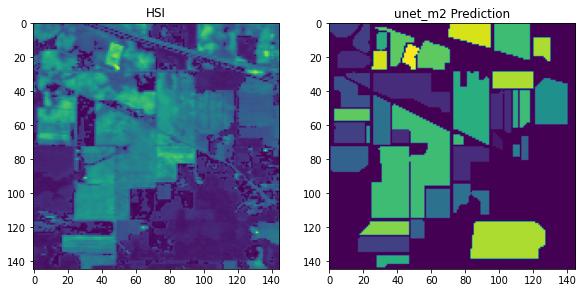

In [36]:
# Plotting the segmentation after identifying the best class for overlapping patches
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(HS_image_1[:,:,20])
plt.title('HSI')
plt.subplot(132)
plt.imshow(HS_image_1_segment)
plt.title('unet_m2 Prediction')
plt.show()

In [31]:
HS_image_2 = scipy.io.loadmat('test_image_full.mat')['test_img']
# HS_image

In [32]:
# %%timeit
HS_image_2_segment = Predict_HSI_segment(HS_image_2)

Processing time (sec):  12.042461156845093


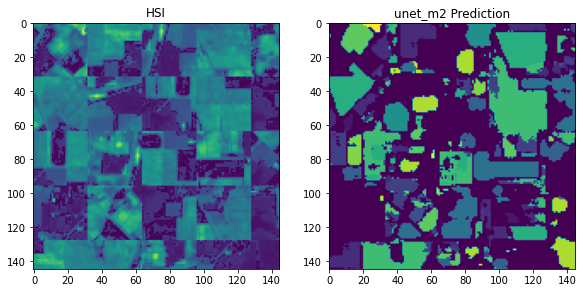

In [33]:
# Plotting the segmentation after identifying the best class for overlapping patches
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(HS_image_2[:,:,20])
plt.title('HSI')
plt.subplot(132)
plt.imshow(HS_image_2_segment)
plt.title('unet_m2 Prediction')
plt.show()